In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.linalg import block_diag

In [41]:
# friction map:  [[0.09041 0.1     0.09041]
#                 [0.1     0.09041 0.09041]
#                 [0.1     0.1568  0.1    ]]

In [42]:
plt.close("all")

In [43]:
data = "../data/robot_data.csv"


In [44]:
df = pd.read_csv(data, index_col=0)

In [45]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
ax[0].hist(df.wheel_l)
ax[0].set_title('wheel_l')
ax[1].hist(df.wheel_r)
ax[1].set_title('wheel_r')
plt.show()

In [46]:
df.wheel_l.min(), df.wheel_l.max()

(0.4267151266695041, 10.78306710094666)

In [47]:
df.wheel_r.min(), df.wheel_r.max()

(2.059677336104444, 11.012253585858764)

In [48]:
df

,wheel_l,wheel_r,beta_l,beta_r,alpha,i,j
0,2.951473,3.223729,-0.025151,-0.023900,0.030320,1,2
1,4.195919,4.210596,-0.005108,0.009406,0.043215,1,2
2,5.499216,5.019863,-0.002574,-0.007017,0.115174,1,2
3,7.160615,5.695565,0.018772,-0.005655,0.062451,1,2
4,7.699737,4.763282,0.004853,-0.031695,0.037491,1,2
...,...,...,...,...,...,...,...
1575,5.639273,9.942123,-0.050181,0.018259,0.015813,0,0
1576,3.108867,10.055020,-0.072674,0.008697,-0.159957,0,0
1577,4.249619,9.101224,-0.003778,0.017636,-0.210222,0,0
1578,5.372323,7.903496,-0.032779,-0.014017,-0.053571,0,0


In [49]:
i_filter = 0
j_filter = 1

In [50]:
# filtered = df[(df.i == i_filter) & (df.j == j_filter)]
# filtered

filtered = df

In [51]:
# filtered = filtered[(filtered.wheel_l > 9) & (filtered.wheel_r > 11)]
# filtered.sort_values(["wheel_l","wheel_r"])

In [52]:
omega_l = filtered.wheel_l.values
omega_r = filtered.wheel_r.values
beta_l = filtered.beta_l.values
beta_r = filtered.beta_r.values
alpha = filtered.alpha.values

In [53]:
%matplotlib tk

In [54]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Residuals")

# Beta_l residuals
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(omega_l, omega_r, beta_l, color="green")
ax1.set_xlabel("omega_l")
ax1.set_ylabel("omega_r")
ax1.set_title("beta_l")
# ax1.view_init(0, 0, 0)

# Beta_r residuals
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(omega_l, omega_r, beta_r, color="orange")
ax2.set_xlabel("omega_l")
ax2.set_ylabel("omega_r")
ax2.set_title("beta_r")
# ax2.view_init(0, 0, 0)

# Alpha residuals
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(omega_l, omega_r, alpha, color="purple")
ax3.set_xlabel("omega_l")
ax3.set_ylabel("omega_r")
ax3.set_title("alpha")
# ax3.view_init(0, 0, 0)

plt.show()

In [55]:
X = np.column_stack((np.ones(len(omega_l)), omega_l, omega_r))
Y = np.column_stack((beta_l, beta_r, alpha))

In [56]:
# OLS regressor

theta_hat_ols = np.linalg.inv(X.T @ X) @ (X.T @ Y)
y_hat_ols = X @ theta_hat_ols

theta_hat_ols

array([[-0.0045595 ,  0.00239074, -0.00107088],
       [ 0.00552652, -0.00603822,  0.0168745 ],
       [-0.00489595,  0.00558813, -0.01673122]])

In [57]:
residuals_ols = Y - y_hat_ols

In [58]:
%matplotlib inline

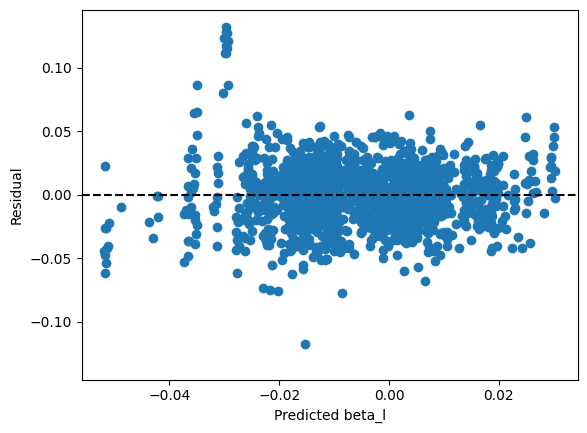

In [59]:
bound = max(abs(residuals_ols[...,0].min()),abs(residuals_ols[...,0].max()))
plt.ylim(-bound*1.1, bound*1.1)
plt.scatter(y_hat_ols[...,0], residuals_ols[...,0])
plt.axhline(0,linestyle='--', color='black')
plt.xlabel("Predicted beta_l")
plt.ylabel("Residual")
plt.show()

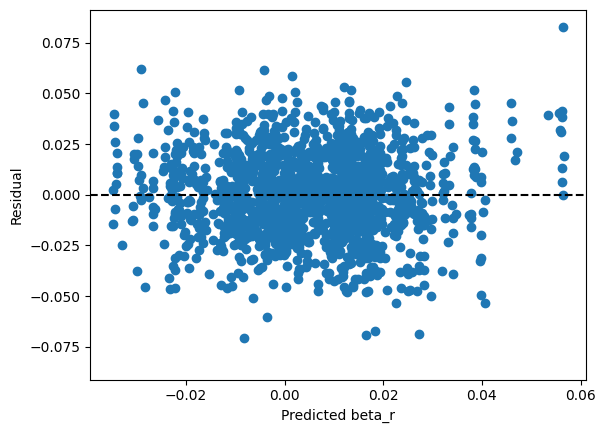

In [60]:
bound = max(abs(residuals_ols[...,1].min()),abs(residuals_ols[...,1].max()))
plt.ylim(-bound*1.1, bound*1.1)
plt.scatter(y_hat_ols[...,1], residuals_ols[...,1])
plt.axhline(0,linestyle='--', color='black')
plt.xlabel("Predicted beta_r")
plt.ylabel("Residual")
plt.show()

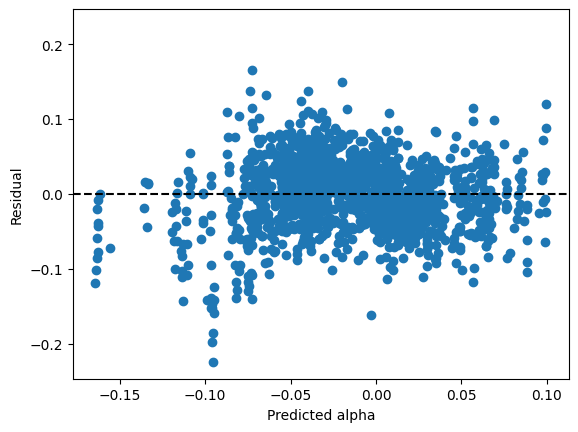

In [61]:
bound = max(abs(residuals_ols[...,2].min()),abs(residuals_ols[...,2].max()))
plt.ylim(-bound*1.1, bound*1.1)
plt.scatter(y_hat_ols[...,2], residuals_ols[...,2])
plt.axhline(0,linestyle='--', color='black')
plt.xlabel("Predicted alpha")
plt.ylabel("Residual")
plt.show()

In [62]:
# WLS regressor

weights_l = 1 / (residuals_ols[:, 0] ** 2 + 1e-20) 
weights_r = 1 / (residuals_ols[:, 1] ** 2 + 1e-20) 
weights_alpha = 1 / (residuals_ols[:, 2] ** 2 + 1e-20)

W_l = np.diag(weights_l)
W_r = np.diag(weights_r)
W_alpha = np.diag(weights_alpha)

W = block_diag(W_l, W_r, W_alpha)

X_expanded = np.kron(np.eye(3), X)

XTWX_inv = np.linalg.inv(X_expanded.T @ W @ X_expanded)
XTWy = X_expanded.T @ W @ Y.flatten(order='F')
theta_hat_wls_flat = XTWX_inv @ XTWy

theta_hat_wls = theta_hat_wls_flat.reshape(3, -1).T
y_hat_wls = X @ theta_hat_wls

theta_hat_wls

array([[-0.00462547,  0.00228277, -0.00107989],
       [ 0.00554104, -0.00603586,  0.01687061],
       [-0.00489921,  0.00559518, -0.01672829]])

In [63]:
residuals_wls = Y - y_hat_wls

In [64]:
std_residuals_beta_l = residuals_wls[:, 0] * np.sqrt(weights_l)
std_residuals_beta_r = residuals_wls[:, 1] * np.sqrt(weights_r)
std_residuals_alpha = residuals_wls[:, 2] * np.sqrt(weights_alpha)

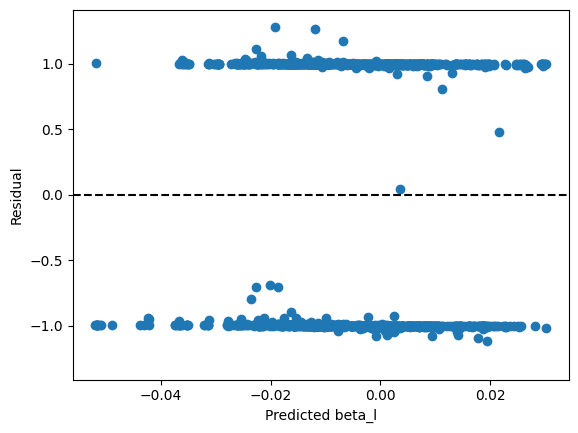

In [65]:
bound = max(abs(std_residuals_beta_l.min()),abs(std_residuals_beta_l.max()))
plt.ylim(-bound*1.1, bound*1.1)
plt.scatter(y_hat_wls[...,0], std_residuals_beta_l)
plt.axhline(0,linestyle='--', color='black')
plt.xlabel("Predicted beta_l")
plt.ylabel("Residual")
plt.show()

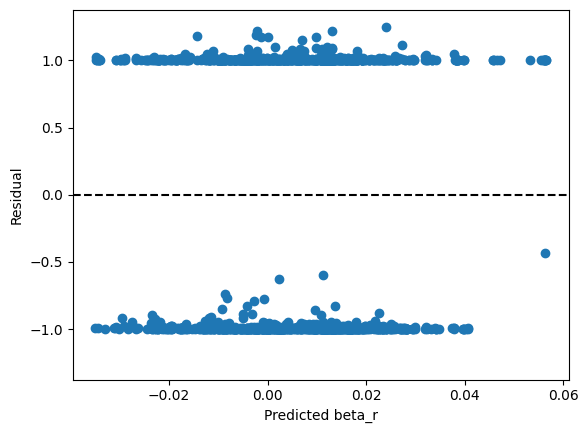

In [66]:
bound = max(abs(std_residuals_beta_r.min()),abs(std_residuals_beta_r.max()))
plt.ylim(-bound*1.1, bound*1.1)
plt.scatter(y_hat_wls[...,1], std_residuals_beta_r)
plt.axhline(0,linestyle='--', color='black')
plt.xlabel("Predicted beta_r")
plt.ylabel("Residual")
plt.show()

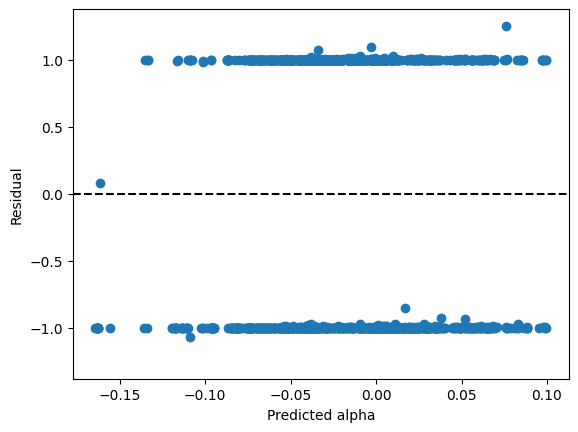

In [67]:
bound = max(abs(std_residuals_alpha.min()),abs(std_residuals_alpha.max()))
plt.ylim(-bound*1.1, bound*1.1)
plt.scatter(y_hat_wls[...,2], std_residuals_alpha)
plt.axhline(0,linestyle='--', color='black')
plt.xlabel("Predicted alpha")
plt.ylabel("Residual")
plt.show()

In [68]:
%matplotlib tk

In [69]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Data")

# Beta_l residuals
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(omega_l, omega_r, beta_l, color="green")
ax1.scatter(omega_l, omega_r, y_hat_ols[...,0], color="blue")
ax1.scatter(omega_l, omega_r, y_hat_wls[...,0], color="red")
ax1.set_xlabel("omega_l")
ax1.set_ylabel("omega_r")
ax1.set_title("beta_l")
# ax1.view_init(0, 0, 0)

# Beta_r residuals
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(omega_l, omega_r, beta_r, color="orange")
ax2.scatter(omega_l, omega_r, y_hat_ols[...,1], color="blue")
ax2.scatter(omega_l, omega_r, y_hat_wls[...,1], color="red")
ax2.set_xlabel("omega_l")
ax2.set_ylabel("omega_r")
ax2.set_title("beta_r")
# ax2.view_init(0, 0, 0)

# Alpha residuals
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(omega_l, omega_r, alpha, color="purple")
ax3.scatter(omega_l, omega_r, y_hat_ols[...,2], color="blue")
ax3.scatter(omega_l, omega_r, y_hat_wls[...,2], color="red")
ax3.set_xlabel("omega_l")
ax3.set_ylabel("omega_r")
ax3.set_title("alpha")
# ax3.view_init(0, 0, 0)

plt.show()

In [70]:
# Extract coefficients from WLS estimation
theta_0_l, theta_1_l, theta_2_l = theta_hat_wls[:, 0]  # Coefficients for beta_l
theta_0_r, theta_1_r, theta_2_r = theta_hat_wls[:, 1]  # Coefficients for beta_r
theta_0_alpha, theta_1_alpha, theta_2_alpha = theta_hat_wls[:, 2]  # Coefficients for alpha

# Create a grid of values for omega_l and omega_r
omega_l_grid, omega_r_grid = np.meshgrid(np.linspace(omega_l.min(), omega_l.max(), 100),
                                         np.linspace(omega_r.min(), omega_r.max(), 100))

# Calculate the corresponding beta_l, beta_r, and alpha values on the grid
beta_l_grid = theta_0_l + theta_1_l * omega_l_grid + theta_2_l * omega_r_grid
beta_r_grid = theta_0_r + theta_1_r * omega_l_grid + theta_2_r * omega_r_grid
alpha_grid = theta_0_alpha + theta_1_alpha * omega_l_grid + theta_2_alpha * omega_r_grid

In [71]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Residuals")



# Beta_l residuals
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(omega_l, omega_r, beta_l, color="green")
ax1.scatter(omega_l, omega_r, y_hat_ols[...,0], color="blue")
ax1.scatter(omega_l, omega_r, y_hat_wls[...,0], color="red")
ax1.plot_surface(omega_l_grid, omega_r_grid, beta_l_grid, alpha=1)
ax1.set_xlabel("omega_l")
ax1.set_ylabel("omega_r")
ax1.set_title("beta_l")
# ax1.view_init(0, 0, 0)

# Beta_r residuals
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(omega_l, omega_r, beta_r, color="orange")
ax2.scatter(omega_l, omega_r, y_hat_ols[...,1], color="blue")
ax2.scatter(omega_l, omega_r, y_hat_wls[...,1], color="red")
ax2.plot_surface(omega_l_grid, omega_r_grid, beta_r_grid, alpha=1)
ax2.set_xlabel("omega_l")
ax2.set_ylabel("omega_r")
ax2.set_title("beta_r")
# ax2.view_init(0, 0, 0)

# Alpha residuals
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(omega_l, omega_r, alpha, color="purple")
ax3.scatter(omega_l, omega_r, y_hat_ols[...,2], color="blue")
ax3.scatter(omega_l, omega_r, y_hat_wls[...,2], color="red")
ax3.plot_surface(omega_l_grid, omega_r_grid, alpha_grid, alpha=1)
ax3.set_xlabel("omega_l")
ax3.set_ylabel("omega_r")
ax3.set_title("alpha")
# ax3.view_init(0, 0, 0)

plt.show()

In [72]:
print(f"beta_l r2: ols={r2_score(Y[...,0], y_hat_ols[...,0])}, wls={r2_score(Y[...,0], y_hat_wls[...,0])}")
print(f"beta_r r2: ols={r2_score(Y[...,1], y_hat_ols[...,1])}, wls={r2_score(Y[...,1], y_hat_wls[...,1])}")
print(f"alpha r2: ols={r2_score(Y[...,2], y_hat_ols[...,2])}, wls={r2_score(Y[...,2], y_hat_wls[...,2])}")

beta_l r2: ols=0.2504997759422609, wls=0.25049868385297214
beta_r r2: ols=0.36155170980402807, wls=0.3615484976576754
alpha r2: ols=0.4924620426068571, wls=0.49246198623343174


In [73]:
df_1 = pd.read_csv("data/1.csv", index_col=0) 

In [74]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Residuals")

omega_l_gt = df_1.wheel_l.values
omega_r_gt = df_1.wheel_r.values
beta_l_gt = df_1.beta_l.values
beta_r_gt = df_1.beta_r.values
alpha_gt = df_1.alpha.values

# Beta_l residuals
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(omega_l_gt, omega_r_gt, beta_l_gt, color="green")
ax1.scatter(omega_l, omega_r, beta_l, color="gray")
ax1.plot_surface(omega_l_grid, omega_r_grid, beta_l_grid, alpha=1)
ax1.set_xlabel("omega_l")
ax1.set_ylabel("omega_r")
ax1.set_title("beta_l")
# ax1.view_init(0, 0, 0)

# Beta_r residuals
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(omega_l_gt, omega_r_gt, beta_r_gt, color="orange")
ax2.scatter(omega_l, omega_r, beta_r, color="gray")
ax2.plot_surface(omega_l_grid, omega_r_grid, beta_r_grid, alpha=1)
ax2.set_xlabel("omega_l")
ax2.set_ylabel("omega_r")
ax2.set_title("beta_r")
# ax2.view_init(0, 0, 0)

# Alpha residuals
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(omega_l_gt, omega_r_gt, alpha_gt, color="purple")
ax3.scatter(omega_l, omega_r, alpha, color="gray")
ax3.plot_surface(omega_l_grid, omega_r_grid, alpha_grid, alpha=1)
ax3.set_xlabel("omega_l")
ax3.set_ylabel("omega_r")
ax3.set_title("alpha")
# ax3.view_init(0, 0, 0)

plt.show()

In [75]:
X = np.column_stack((np.ones(len(omega_l_gt)), omega_l_gt, omega_r_gt))
Y = np.column_stack((beta_l_gt, beta_r_gt, alpha_gt))

In [76]:
y_hat_wls_gt = X @ theta_hat_wls

In [77]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Data")

# Beta_l residuals
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(omega_l_gt, omega_r_gt, beta_l_gt, color="green")
ax1.scatter(omega_l_gt, omega_r_gt, y_hat_wls_gt[...,0], color="red")
ax1.set_xlabel("omega_l")
ax1.set_ylabel("omega_r")
ax1.set_title("beta_l")
# ax1.view_init(0, 0, 0)

# Beta_r residuals
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(omega_l_gt, omega_r_gt, beta_r_gt, color="orange")
ax2.scatter(omega_l_gt, omega_r_gt, y_hat_wls_gt[...,1], color="red")
ax2.set_xlabel("omega_l")
ax2.set_ylabel("omega_r")
ax2.set_title("beta_r")
# ax2.view_init(0, 0, 0)

# Alpha residuals
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(omega_l_gt, omega_r_gt, alpha_gt, color="purple")
ax3.scatter(omega_l_gt, omega_r_gt, y_hat_wls_gt[...,2], color="red")
ax3.set_xlabel("omega_l")
ax3.set_ylabel("omega_r")
ax3.set_title("alpha")
# ax3.view_init(0, 0, 0)

plt.show()

In [78]:
print(f"beta_l_gt r2: wls={r2_score(Y[...,0], y_hat_wls_gt[...,0])}")
print(f"beta_r_gt r2: wls={r2_score(Y[...,1], y_hat_wls_gt[...,1])}")
print(f"alpha_gt r2: wls={r2_score(Y[...,2], y_hat_wls_gt[...,2])}")

beta_l_gt r2: wls=0.853603996116255
beta_r_gt r2: wls=0.8664103628912849
alpha_gt r2: wls=0.7900074259937206
